In [ ]:
!pip install timm medmnist scikit-learn matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 7.9 MB/s eta 0:00:00


In [ ]:
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from medmnist import PneumoniaMNIST, INFO
from torchvision import transforms


In [ ]:
info = INFO["pneumoniamnist"]

train_data = PneumoniaMNIST(split="train", download=True)
val_data   = PneumoniaMNIST(split="val", download=True)
test_data  = PneumoniaMNIST(split="test", download=True)


100%|██████████| 4.17M/4.17M [00:07<00:00, 578kB/s]


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),
    transforms.Normalize([0.5]*3,[0.5]*3)
])

train_data.transform = transform
val_data.transform   = transform
test_data.transform  = transform


In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32)
test_loader  = DataLoader(test_data, batch_size=32)


In [ ]:
model = timm.create_model(
    "vit_base_patch16_siglip_224",
    pretrained=True,
    num_classes=2
)

device = "cuda"
model = model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/372M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)


In [ ]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(10):

    model.train()
    correct,total,loss_sum = 0,0,0
    for x,y in train_loader:
        x,y = x.to(device), y.squeeze().long().to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out,y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        correct += (out.argmax(1)==y).sum().item()
        total += y.size(0)

    train_losses.append(loss_sum/len(train_loader))
    train_accs.append(correct/total)


    model.eval()
    correct,total,loss_sum = 0,0,0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.squeeze().long().to(device)
            out = model(x)
            loss = criterion(out,y)

            loss_sum += loss.item()
            correct += (out.argmax(1)==y).sum().item()
            total += y.size(0)

    val_losses.append(loss_sum/len(val_loader))
    val_accs.append(correct/total)

    print("SIGLIP Epoch",epoch+1,": Train Acc=",train_acc[-1], "Val Acc=",val_accs[-1])


SIGLIP Epoch 1: Train Acc=0.766, Val Acc=0.758
SIGLIP Epoch 2: Train Acc=0.916, Val Acc=0.927
SIGLIP Epoch 3: Train Acc=0.942, Val Acc=0.964
SIGLIP Epoch 4: Train Acc=0.955, Val Acc=0.956
SIGLIP Epoch 5: Train Acc=0.957, Val Acc=0.882
SIGLIP Epoch 6: Train Acc=0.941, Val Acc=0.920
SIGLIP Epoch 7: Train Acc=0.960, Val Acc=0.971
SIGLIP Epoch 8: Train Acc=0.968, Val Acc=0.964
SIGLIP Epoch 9: Train Acc=0.956, Val Acc=0.954
SIGLIP Epoch 10: Train Acc=0.965, Val Acc=0.952


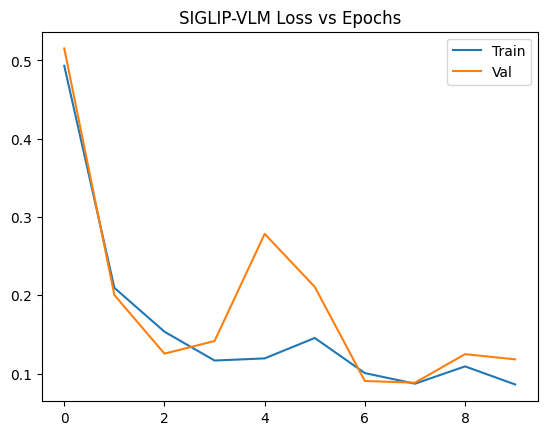

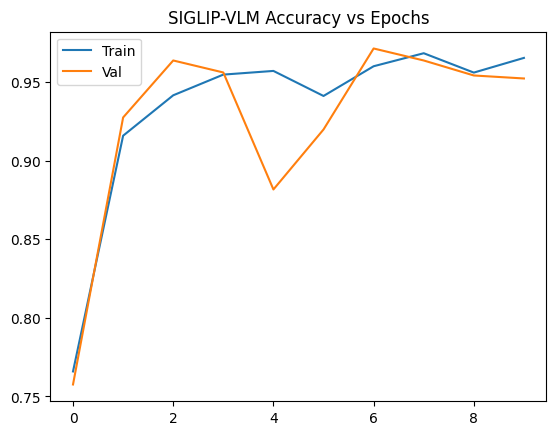

In [ ]:
plt.plot(train_losses,label="Train")
plt.plot(val_losses,label="Val")
plt.title("SIGLIP-VLM Loss vs Epochs")
plt.legend()
plt.show()

plt.plot(train_accs,label="Train")
plt.plot(val_accs,label="Val")
plt.title("SIGLIP-VLM Accuracy vs Epochs")
plt.legend()
plt.show()


In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x,y in test_loader:
        x = x.to(device)
        out = model(x)
        y_pred.extend(out.argmax(1).cpu().numpy())
        y_true.extend(y.squeeze().numpy())


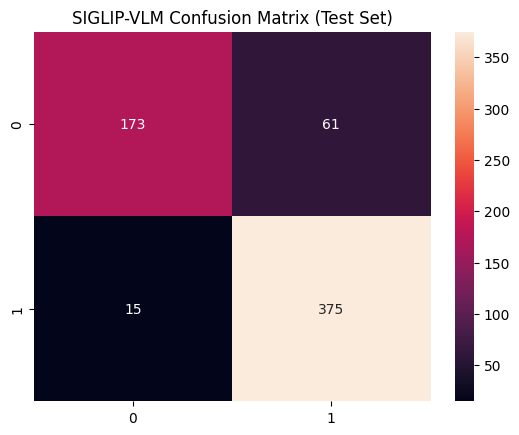

In [ ]:
cm = confusion_matrix(y_true,y_pred)
sns.heatmap(cm,annot=True,fmt="d")
plt.title("SIGLIP-VLM Confusion Matrix (Test Set)")
plt.show()


In [ ]:
print(classification_report(
    y_true, y_pred,
    target_names=["Normal","Pneumonia"],
    digits=4
))


              precision    recall  f1-score   support

      Normal     0.9202    0.7393    0.8199       234
   Pneumonia     0.8601    0.9615    0.9080       390

    accuracy                         0.8782       624
   macro avg     0.8902    0.8504    0.8639       624
weighted avg     0.8826    0.8782    0.8750       624



In [ ]:
acc = accuracy_score(y_true,y_pred)
prec,rec,f1,_ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
prec_m,rec_m,f1_m,_ = precision_recall_fscore_support(y_true,y_pred,average="macro")

print("Test Accuracy:",acc)
print("Weighted P,R,F1:",prec,rec,f1)
print("Macro    P,R,F1:",prec_m,rec_m,f1_m)


Test Accuracy: 0.8782051282051282
Weighted P,R,F1: 0.8826371266835839 0.8782051282051282 0.8749584017075381
Macro    P,R,F1: 0.8901522545383564 0.8504273504273505 0.863947764020059
